# Base Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [60]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [61]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [83]:
# years sliding window
window_size = 12
steps_ahead = 48 * 7   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [84]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [85]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


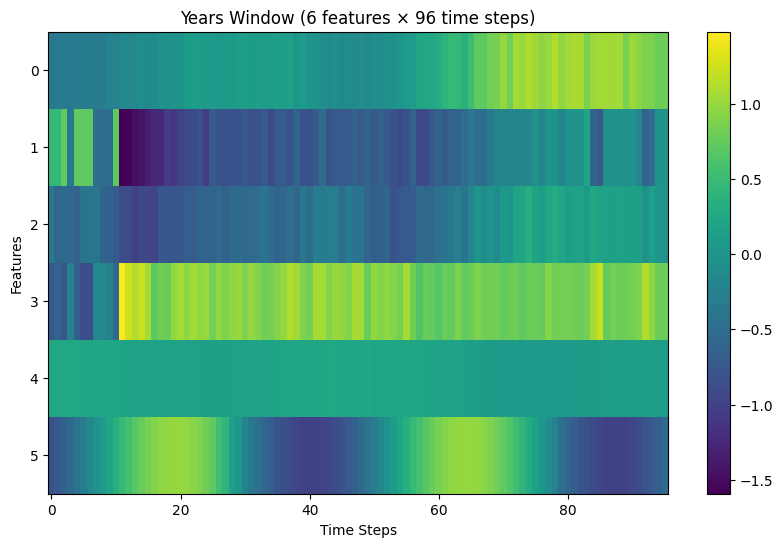

In [86]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

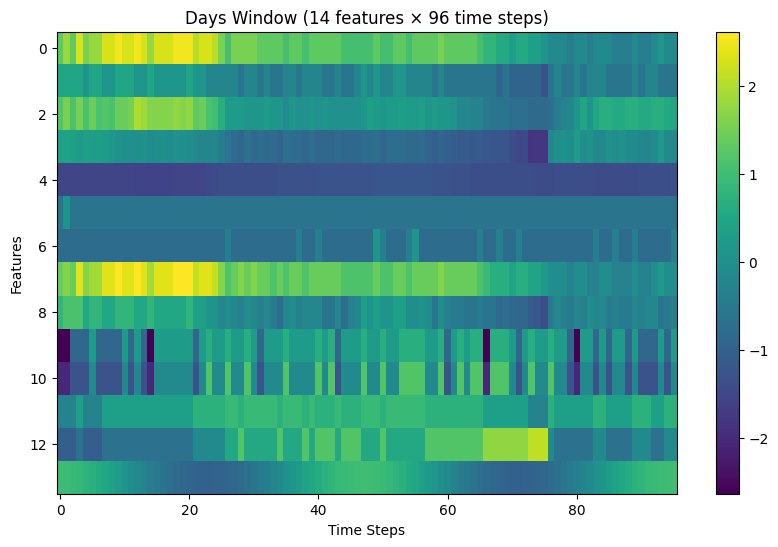

In [87]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# MPL One Target (WVHT) Years Dataset

In [88]:
# flatten 7×num_features into one vector
X_years_flat = X_years.reshape(X_years.shape[0], -1)

In [89]:
# train/val split
X_train_years, X_val_years, y_train_years, y_val_years = train_test_split(
    X_years_flat, y_years, test_size=0.2, shuffle=False
)

In [90]:
# build mlp
input_dim_years = X_train_years.shape[1]

model_years = nn.Sequential(
    nn.Linear(input_dim_years, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)


In [91]:
# convert to tensors
X_train_years_t = torch.tensor(X_train_years, dtype=torch.float32)
y_train_years_t = torch.tensor(y_train_years, dtype=torch.float32).view(-1, 1)

X_val_years_t = torch.tensor(X_val_years, dtype=torch.float32)
y_val_years_t = torch.tensor(y_val_years, dtype=torch.float32).view(-1, 1)

In [92]:
# train setup
optimizer_years = torch.optim.Adam(model_years.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 251
train_losses_years = []
val_losses_years = []

# training loop
for epoch in range(epochs):
    model_years.train()
    optimizer_years.zero_grad()

    pred = model_years(X_train_years_t)
    loss = loss_fn(pred, y_train_years_t)
    loss.backward()
    optimizer_years.step()

    # validation
    model_years.eval()
    with torch.no_grad():
        val_pred = model_years(X_val_years_t)
        val_loss = loss_fn(val_pred, y_val_years_t)

    train_losses_years.append(loss.item())
    val_losses_years.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"Years — Epoch {epoch}: train {loss.item():.4f}, val {val_loss.item():.4f}")

Years — Epoch 0: train 1.1995, val 0.2195
Years — Epoch 25: train 1.1924, val 0.2140
Years — Epoch 50: train 1.1761, val 0.2182
Years — Epoch 75: train 1.1344, val 0.2236
Years — Epoch 100: train 1.0225, val 0.2357
Years — Epoch 125: train 0.8590, val 0.2351
Years — Epoch 150: train 0.6912, val 0.2410
Years — Epoch 175: train 0.5821, val 0.2391
Years — Epoch 200: train 0.5055, val 0.2450
Years — Epoch 225: train 0.4206, val 0.2553
Years — Epoch 250: train 0.3632, val 0.2590


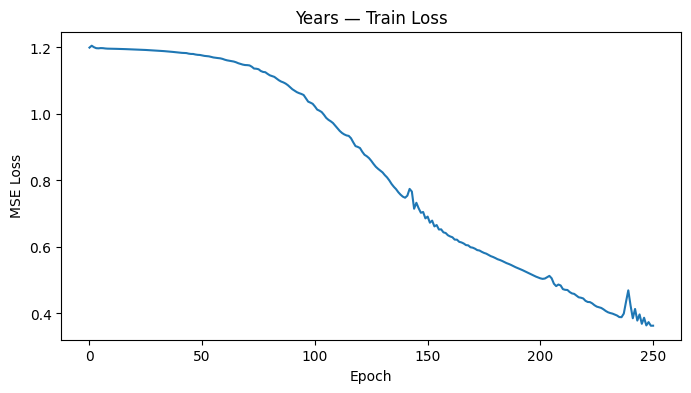

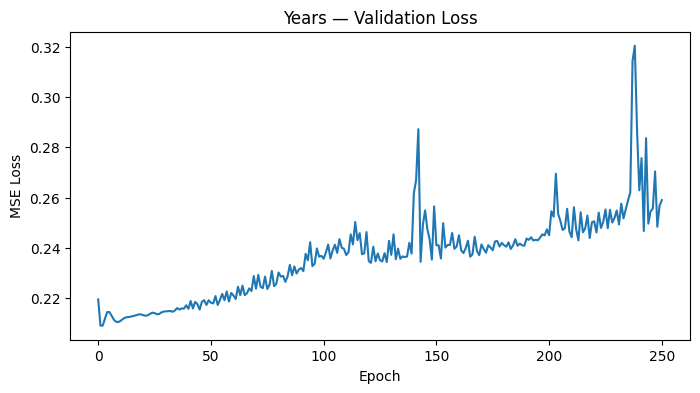

In [93]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_years)
plt.title("Years — Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_losses_years)
plt.title("Years — Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# MPL One Target (WVHT) Days Dataset

In [94]:
# flatten 7×num_features into one vector
X_days_flat = X_days.reshape(X_days.shape[0], -1)

In [95]:
# train/val split
X_train_days, X_val_days, y_train_days, y_val_days = train_test_split(
    X_days_flat, y_days, test_size=0.2, shuffle=False
)

In [96]:
# build mlp
input_dim_days = X_train_days.shape[1]

model_days = nn.Sequential(
    nn.Linear(input_dim_days, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

In [97]:
# convert to tensors
X_train_days_t = torch.tensor(X_train_days, dtype=torch.float32)
y_train_days_t = torch.tensor(y_train_days, dtype=torch.float32).view(-1, 1)

X_val_days_t = torch.tensor(X_val_days, dtype=torch.float32)
y_val_days_t = torch.tensor(y_val_days, dtype=torch.float32).view(-1, 1)

In [98]:
# train setup
optimizer_days = torch.optim.Adam(model_days.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 251
train_losses_days = []
val_losses_days = []

# training loop
for epoch in range(epochs):
    model_days.train()
    optimizer_days.zero_grad()

    pred = model_days(X_train_days_t)
    loss = loss_fn(pred, y_train_days_t)
    loss.backward()
    optimizer_days.step()

    # validation
    model_days.eval()
    with torch.no_grad():
        val_pred = model_days(X_val_days_t)
        val_loss = loss_fn(val_pred, y_val_days_t)

    train_losses_days.append(loss.item())
    val_losses_days.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"Days — Epoch {epoch}: train {loss.item():.4f}, val {val_loss.item():.4f}")

Days — Epoch 0: train 1.1464, val 0.3823
Days — Epoch 25: train 0.2959, val 2.9468
Days — Epoch 50: train 0.1715, val 4.4280
Days — Epoch 75: train 0.0914, val 5.0968
Days — Epoch 100: train 0.0407, val 5.1812
Days — Epoch 125: train 0.0182, val 5.2696
Days — Epoch 150: train 0.0097, val 5.4015
Days — Epoch 175: train 0.0059, val 5.5023
Days — Epoch 200: train 0.0043, val 5.6476
Days — Epoch 225: train 0.0028, val 5.6516
Days — Epoch 250: train 0.0020, val 5.7075


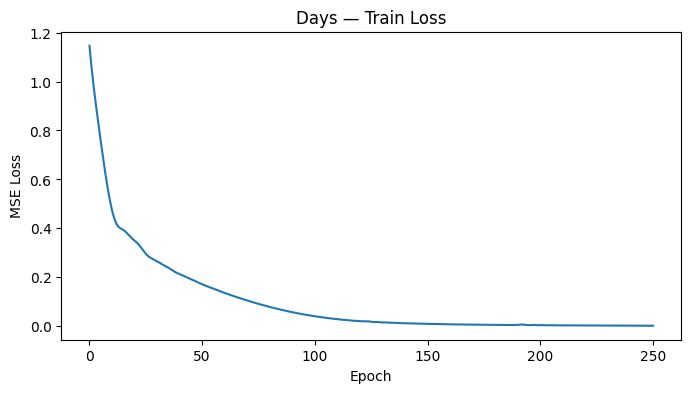

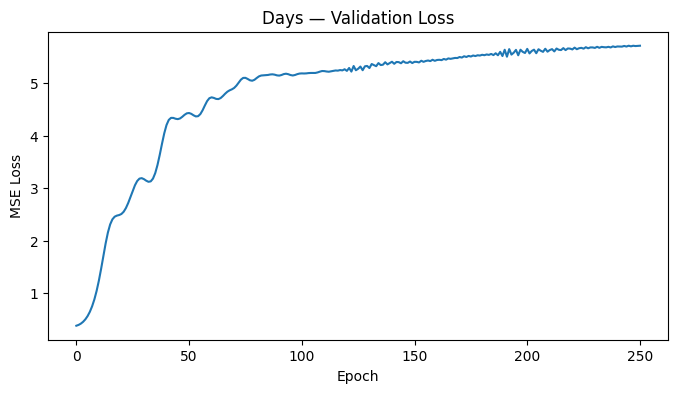

In [99]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_days)
plt.title("Days — Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_losses_days)
plt.title("Days — Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# Real vs Predictions

In [100]:
# convert validation sets
X_val_years_t = torch.tensor(X_val_years, dtype=torch.float32)
X_val_days_t  = torch.tensor(X_val_days,  dtype=torch.float32)

y_val_years_t = torch.tensor(y_val_years, dtype=torch.float32).view(-1,1)
y_val_days_t  = torch.tensor(y_val_days,  dtype=torch.float32).view(-1,1)

In [101]:
model_years.eval()
model_days.eval()

with torch.no_grad():
    pred_years = model_years(X_val_years_t).cpu().numpy().flatten()
    pred_days  = model_days(X_val_days_t).cpu().numpy().flatten()

real_years = y_val_years_t.cpu().numpy().flatten()
real_days  = y_val_days_t.cpu().numpy().flatten()

In [102]:
# 7 days worth of 30-min samples
plot_len = 336

real_days_7  = real_days[:plot_len]
pred_days_7  = pred_days[:plot_len]
pred_years_7 = pred_years[:plot_len]

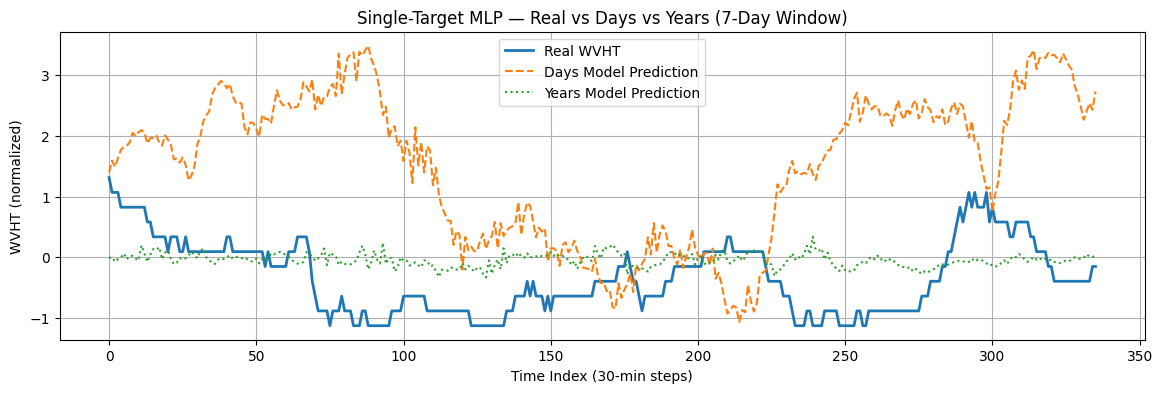

In [103]:
plt.figure(figsize=(14,4))

plt.plot(real_days_7,       label="Real WVHT", linewidth=2)
plt.plot(pred_days_7,  label="Days Model Prediction", linestyle="--")
plt.plot(pred_years_7, label="Years Model Prediction", linestyle=":")

plt.title("Single-Target MLP — Real vs Days vs Years (7-Day Window)")
plt.xlabel("Time Index (30-min steps)")
plt.ylabel("WVHT (normalized)")
plt.grid(True)
plt.legend()
plt.show()